# Probabilistic Simulation for QA

How many tests we need to run to be sure that there are no errors introduced because of changes we made? This is the question we are going to answer using probabilistic simulations. Real life example from my work. We did it for TXN backtesting.


## What Is TXN Backtesting

TXN stands for Transaction check - which is a monitoring tool that executes several action steps in headless Chrome instance on our check servers. We support 26 different step types (commands and validations) that allows our customers to simulate user flows on their websites to ensure that everything works as expected.

We call backtesting a procedure of checking new versions of our software (or chrome version upgrades) using real clients' checks (scripts). During this procedure we run checks using old and new versions and compare results. Ideally results (OK/Not OK) in the new and old versions should be the same.

Why we need backtesting? Aren't regression tests enough? Appears not. We have such tests that checks each step type on our synthetic examples and sometimes they miss bugs which are detected by backtesting. Second issue that can be missed by our tests is backward comatibility of the new versions. Sometimes new versions introduce slight changes in how our steps work and this can result in false positives alerts to our clients which we want to avoid at all costs. 

Ideally we would want to test all existing clients' checks for every new release, but practically this is not possible since there are too much checks and backtesting will take too much time. So we do backtesting only on some randomly selected subset of checks. Question is how many checks we need to backtest to be sure there are no errors?

So our goal is to formalize approach of selecting the number of checks we need to backtest. We want to answer one of the following questions:
 * How much checks we need to backtest to be sure that there is no errors with the certain level of probability or
 * If we test `X` checks what is the probability that tere is no errors
 

## Probability of missing an Error

Let's caclulate probability of missing an error when it is there using simulations

Let
 * `N` is the total number of checks we have
 * `M` is the number of checks that have error 
 
We are going to run our backtesting simulation: we will randomly choose elements from our checks and see if there are any broken ones. We run this procedure many times and the calcualte ratio of how many times we successfully 
detected broken checks to the total number of runs. This will be our probablitiy of detecting bugs via backtesting.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# experiment
def simulate(total_checks, num_errors, backtest, num_experiments=10000):
    checks = np.zeros(total_checks)
    checks[:num_errors] = 1  # errors
    np.random.shuffle(checks)
    errors_detected = 0
    for i in range(num_experiments):
        X = np.random.choice(checks, backtest, replace=False)
        errors_detected += sum(X) != 0
    
    return errors_detected / num_experiments

In [11]:
N = 2000
M = 1 # 1 means only 1 check fails in new version
backtest_size = 100
simulate(N, M, backtest_size)

0.0511

So what we have here is the probablity of detecting an error running backtest on 100 checks out of 1852 in case there is a single error in all checks.

Let's see how this probablity changes if we increase the number of checks we are backtesting

In [4]:
x = []
y = []
for backtest_size in range(100, 1852, 100):
    x.append(backtest_size)
    y.append(simulate(N, 1, backtest_size))

let's see it on a graph

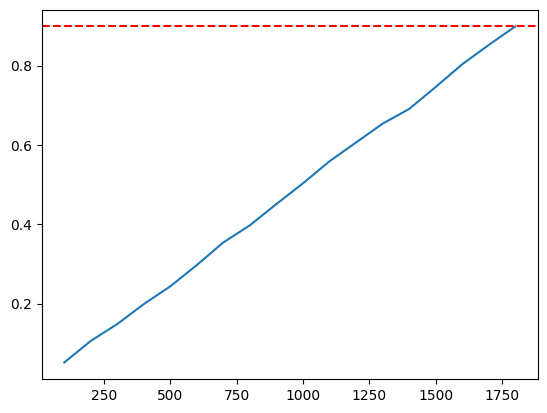

In [5]:
plt.plot(x, y)
plt.axhline(y=0.9, color='red', linestyle='--')
plt.show()

So we can see that to catch a single error with probability more than 90% we need to backtest almost all checks.

This was very specific edge case when error occurs only in a single check. In reality when we introduce an error in the new version of software usually many checks got broken. How to estimate? 

Our checks consist of a number of steps and each step can be only of a certain type. There are only 26 different step types. Let's assume we've introduced an error only in 1 step and that all steps are uniformly distributes over all checks we have (in reality of course there are popupalar and less popular steps), then the number of broken checks will be N/26

In [12]:
M = N // 26
M

76

Let's run our simulation again with the new number of failed checks

In [13]:
x = []
y = []
for backtest_size in range(100, N, 100):
    x.append(backtest_size)
    y.append(simulate(N, M, backtest_size, num_experiments=1000))

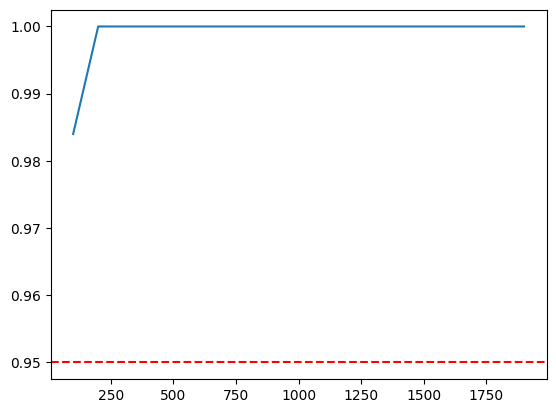

In [14]:
plt.plot(x, y)
plt.axhline(y=0.95, color='red', linestyle='--')
plt.show()

We see that at **100 checks we have more than 95% probability** of detecting a failure, when there is an error on any step that affects all checks. Thinking a bit we realize that this number is also not very practical. There are errors that can affect checks partially. So we need to come up with another condition.

Since we really care about false alarms we can set a reasonable threshold of how many false alarms are acceptable and manageable by our support department. After internal consultations we decided that 1% of fals alarms is OK for us. Let see what numbers this gives us.

In [15]:
M = int(N * 0.01)
M

20

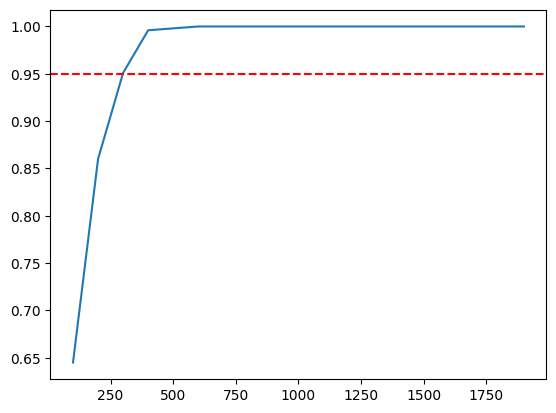

In [16]:
x = []
y = []
for backtest_size in range(100, N, 100):
    x.append(backtest_size)
    y.append(simulate(N, M, backtest_size, num_experiments=1000))
    
plt.plot(x, y)
plt.axhline(y=0.95, color='red', linestyle='--')
plt.show()

We see that between 250 and 500 checks we achieve the desired level of confidence. Let's write a function that can find the number more preciesly by running several simulaions adjusting backtest size on each iteration to make our probability to be close to the desired confidence value with defined prescision

In [17]:
def sample_size_finder(N, M, start=100, confidence=0.95, prescision=0.01, num_experiments=1000, verbose=False):
    delta = 0 - confidence
    prev_delta = delta
    backtest_size = start
    backtest_increase = backtest_size
    
    while True:
        if verbose:
             print(f'Trying {backtest_size} backtest size, increase={backtest_increase}, delta={delta}')
        prob = simulate(N, M, backtest_size, num_experiments)
        delta = prob - confidence
        if np.abs(delta) <= prescision:
            break
        if delta / prev_delta < 0:
            backtest_increase = int(backtest_increase / 2)
        else:
            backtest_increase *= 2
        if delta < 0:
            backtest_size += backtest_increase
            if backtest_size > N:
                backtest_size = N
        else:
            backtest_size -= backtest_increase
            if backtest_size < 1:
                backtest_size = 1
        previous_delta = delta
    if verbose:
        print(f'Result prob={prob} with {backtest_size} backtest size, delta={delta}')
    return backtest_size
    
sample_size_finder(N, M, 100, verbose=True)

Trying 100 backtest size, increase=100, delta=-0.95
Trying 300 backtest size, increase=200, delta=-0.30199999999999994
Trying 200 backtest size, increase=100, delta=0.01100000000000001
Trying 400 backtest size, increase=200, delta=-0.09399999999999997
Trying 300 backtest size, increase=100, delta=0.038000000000000034
Result prob=0.953 with 300 backtest size, delta=0.0030000000000000027


300

What percent of inital population is it?

In [18]:
300 / M

15.0

Let's explore how backtest size changes when total numbed ot checks changes, but the desired percent of failed checks stays constant and equal 1%

In [19]:
import pandas as pd
from multiprocessing import Pool, cpu_count

res = []
args = [(1000, 10)]
for n in range(10000, 110000, 10000):
    m = n // 100
    args.append((n,m))
    
with Pool(cpu_count() - 1) as p:
    samples = p.starmap(sample_size_finder, args)

for s, (n, m) in zip(samples, args):
    res.append([n, s, s/n])

df = pd.DataFrame(res, columns=['Population', 'Sample size', 'Ratio'])
df

,Population,Sample size,Ratio
0,1000,250,0.250000
1,10000,300,0.030000
2,20000,300,0.015000
3,30000,300,0.010000
4,40000,300,0.007500
5,50000,300,0.006000
6,60000,300,0.005000
7,70000,300,0.004286
8,80000,300,0.003750
9,90000,300,0.003333


Interesting - appears that number of checks we need to test doesn't changes at all and after 300 checks we can be sure that no more than 1% of total checks can fail.

Now lets keep constant absolute number of checks we allow to fail and see how our sample size changes

In [128]:
import pandas as pd
from multiprocessing import Pool, cpu_count

res = []
args = [(1000, 10)]
for n in range(10000, 110000, 10000):
    m = 20
    args.append((n,m))
    
with Pool(cpu_count() - 1) as p:
    samples = p.starmap(sample_size_finder, args)

for s, (n, m) in zip(samples, args):
    res.append([n, s, s/n])

df = pd.DataFrame(res, columns=['Population', 'Sample size', 'Ratio'])
df

,Population,Sample size,Ratio
0,1000,250,0.250000
1,10000,1300,0.130000
2,20000,2700,0.135000
3,30000,3900,0.130000
4,40000,5900,0.147500
5,50000,7100,0.142000
6,60000,7900,0.131667
7,70000,9500,0.135714
8,80000,11100,0.138750
9,90000,12700,0.141111


Let's look at 1 million checks, how many checks we need to backtest to make sure only 20 can fail, guessing that according with previous result the number should be around 15%

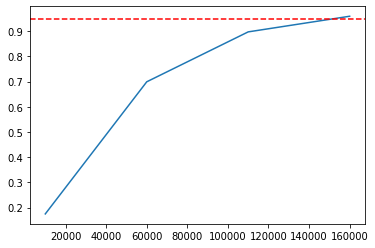

In [125]:
x = []
y = []
for backtest_size in range(10_000, 200_000, 50_000):
    x.append(backtest_size)
    y.append(simulate(1_000_000, 20, backtest_size, num_experiments=1000))
    
plt.plot(x, y)
plt.axhline(y=0.95, color='red', linestyle='--')
plt.show()

Yes, looks like again we need to test around 15% of the population. Let's now do a simulation with 20 errors and 15% of backtest sample size for different total checks numbers:

In [ ]:
res = []
for n in range(10_000, 100_000, 5000):
    p = simulate(n, 20, int(n*0.15))
    res.append((n, p))


In [135]:
df = pd.DataFrame(res, columns=('N', 'Probability'))
df

,N,Probability
0,10000,0.9624
1,15000,0.9653
2,20000,0.9651
3,25000,0.9617
4,30000,0.9575
5,35000,0.9609
6,40000,0.9637
7,45000,0.9582
8,50000,0.9613
9,55000,0.9593


In [136]:
res = []
for n in range(100_000, 1_000_000, 100_000):
    p = simulate(n, 20, int(n*0.15))
    res.append((n, p))
df = pd.DataFrame(res, columns=('N', 'Probability'))
df

,N,Probability
0,100000,0.9577
1,200000,0.9646
2,300000,0.9621
3,400000,0.9596
4,500000,0.9614
5,600000,0.9643
6,700000,0.9612
7,800000,0.9626
8,900000,0.9601


As we can see 15% of population works good for small and large populations up to 1 million.

## Conclusion

With no less than 95% probablilty we can backtest:

* 300 checks to be sure than no more than 1% can fail or
* 15% of total checks to allow no more than 20 checks to fail